In [1]:
using Plots, Interpolations, Polynomials, LinearAlgebra, Measures, Statistics, DataFrames

# Zadanie 1
Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

In [4]:
function Lagrange(x,y,xi)
    l = size(x)[1]
    output = 0

    for i in 1:l
        val = 1
        for j in 1:l
            if i != j 
                val *=(xi-x[j])/(x[i]-x[j])
            end
        end
        output += y[i] * val
    end

    return output
end


Lagrange (generic function with 1 method)

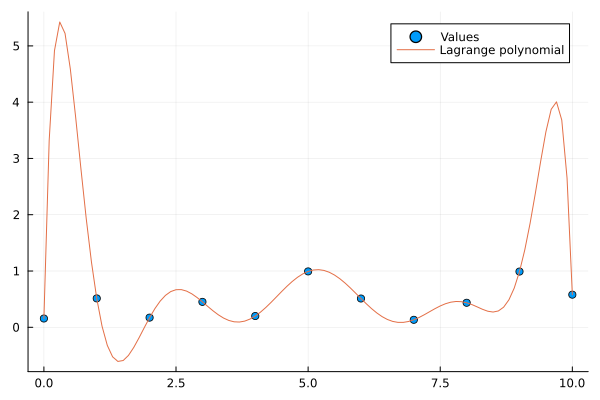

In [5]:
x = 0:1:10
y = [rand() for xi in x]
dist = 0.0:0.1:10

Lagrange_pol = [Lagrange(x,y,d) for d in dist]
scatter(x,y,label="Values")
plot!(dist,Lagrange_pol,label="Lagrange polynomial")

# Zadanie 2
Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

In [96]:
function NewtonInterpolation(x,y)
    l = length(x)[1]
    newt = zeros(l,l)
    newt[: , 1] = y

    for i in 2:l
        for j in i:l
            newt[j,i] = (newt[j,i-1] - newt[j-1,i-1]) / (x[j] - x[j-i+1])
        end
    end
    
    return newt
end

function Newton(x,y,xi)
    l = size(x)[1]
    newt = diag(NewtonInterpolation(x,y))
    output = newt[l]

    for i in l-1:-1:1
        output = output * (xi-x[i]) + newt[i]
    end

    return output
    
end

Newton (generic function with 1 method)

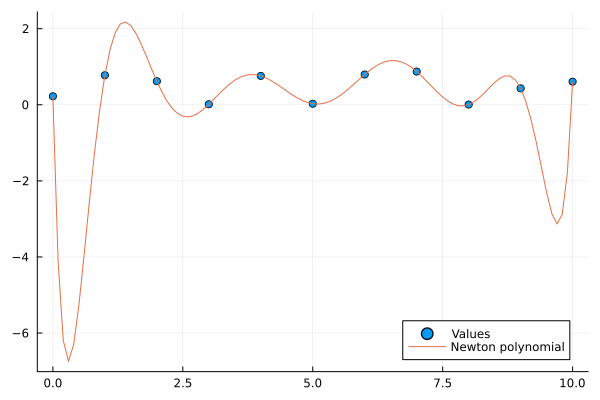

In [97]:
Newton_pol = [Newton(x,y,d) for d in dist]
scatter(x,y,label="Values")
plot!(dist,Newton_pol,label = "Newton polynomial")

# Zadanie 3
Zastosować interpolację wielomianową z pakietu Polynomials do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

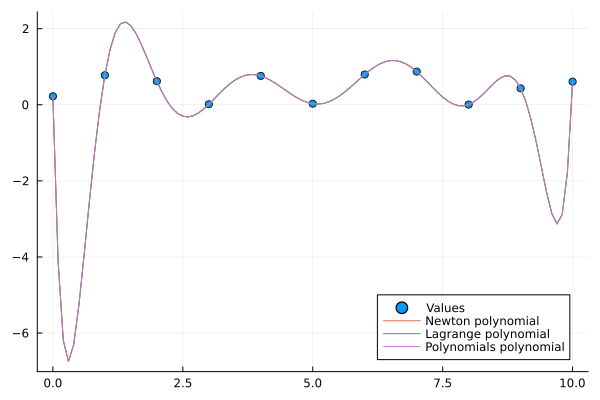

In [98]:
pack = fit(x,y)
plot!(dist,Lagrange_pol,label="Lagrange polynomial")
plot!(pack , extrema(x)...,label="Polynomials polynomial")

Obserwując powyższe wyniki możemy zauważyć, że interpolacje się pokrywają. Taki efekt jest zgodny z założeniem twierdzenia o wielomianie n-tego stopnia.

# Zadanie 4
Porównać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonać pomiaru 10 razy i policzyć wartość średnią oraz oszacować błąd pomiaru za pomocą odchylenia standardowego; wyniki przedstawić na wykresach. <b>(2 pkt)</b>

In [87]:
df = DataFrame(Nodes=Int[],L=Float64[],N1=Float64[],N2=Float64[],P1=Float64[],P2=Float64[])
for i in 10:10:100
    for j in 1:10
        w = 10/i
        test_x = 0:w:10
        test_y = [rand() for xi in test_x]
        test_d = 0:0.01:10
        l , l_t = @timed [Lagrange(test_x,test_y,d) for d in test_d]
        n1 , n1_t = @timed NewtonInterpolation(test_x,test_x)
        n2 , n2_t = @timed [Newton(test_x,test_y,d) for d in test_d]
        p1 , p1_t = @timed fit(test_x,test_y)
        p2 , p2_t = @timed [p1(d) for d in test_d] 
        push!(df,hcat([i],l_t,n1_t,n2_t,p1_t, p2_t))
    end
end

data = combine(groupby(df,:Nodes),:L => mean => :mean_Lagrange,:L => std => :std_Lagrange,
    :N1 => mean => :mean_Newton1, :N1 => std => :std_Newton1,:N2 => mean => :mean_Newton2, :N2 => std => :std_Newton2,
    :P1 => mean => :mean_Polynomial1, :P1 => std => :std_Polynomial1,:P2 => mean => :mean_Polynomial2, :P2 => std => :std_Polynomial2)
println(data)



10×11 DataFrame
 Row │ Nodes  mean_Lagrange  std_Lagrange  mean_Newton1  std_Newton1  mean_Newton2  std_Newton2  mean_Polynomial1  std_Polynomial1  mean_Polynomial2  std_Polynomial2 
     │ Int64  Float64        Float64       Float64       Float64      Float64       Float64      Float64           Float64          Float64           Float64         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │    10     0.0156154    0.0476379      0.00798233   0.0252365     0.0147864    0.0445352           4.56e-6        2.3167e-6         0.00403058       0.0126982
   2 │    20     0.00224452   0.000708979    5.14e-6      2.37122e-6    0.00425316   0.00579354          8.19e-6        1.93818e-6        2.211e-5         6.51621e-6
   3 │    30     0.00536432   0.0011656      9.19e-6      3.00498e-6    0.00619842   0.00129348          1.114e-5       8.0305e-7         2.905e-5      

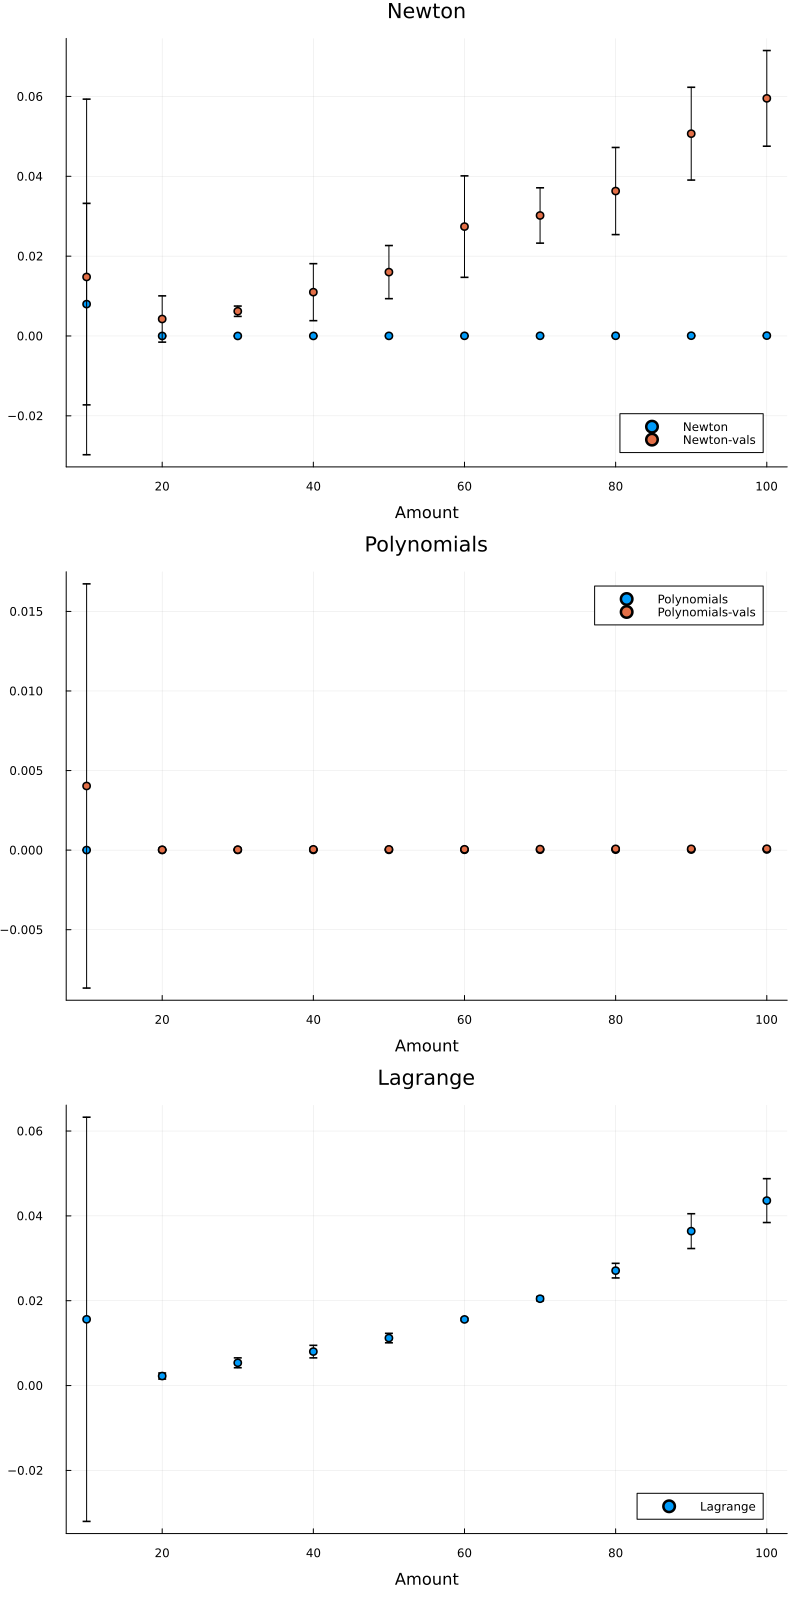

In [102]:
scatter(data.Nodes,
    xlabel = "Amount" , 
    ylabel = "Average time" , 
    size = (800,1600),
    [data.mean_Newton1 , data.mean_Polynomial1 , data.mean_Lagrange, data.mean_Newton2 , data.mean_Polynomial2] ,
    title = ["Newton" "Polynomials" "Lagrange"] ,
    label = ["Newton" "Polynomials" "Lagrange" "Newton-vals" "Polynomials-vals"] ,
    yerr = [data.std_Newton1 data.std_Polynomial1 data.std_Lagrange data.std_Newton2 data.std_Polynomial2],
    layout = grid(3,1))


# Zadanie 5
Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

In [99]:
function Neville(x,y,xi)
    l = size(x)[1]
    out = copy(y)

    for i in 1:l
        for j in i-1:-1:1
            out[j] = (out[j+1]-out[j])*(xi-x[i])/(x[i]-x[j]) + out[j+1]
        end
    end
    return out[1]
    
end

Neville (generic function with 1 method)

In [100]:
using Distributions
example = [rand(Uniform(0.0,10.0)) for t in 1:10]
comp = DataFrame(Neville=Float64[],Lagrange=Float64[],Difference=Float64[])
for ex in example
    push!(comp,(Neville(x,y,ex),Lagrange(x,y,ex),abs(Neville(x,y,ex)-Lagrange(x,y,ex))))
end
println(comp)


10×3 DataFrame
 Row │ Neville     Lagrange    Difference  
     │ Float64     Float64     Float64     
─────┼─────────────────────────────────────
   1 │  1.14455     1.14455    0.0
   2 │ -0.0305713  -0.0305713  6.245e-17
   3 │  0.749503    0.749503   1.11022e-16
   4 │  1.28302     1.28302    3.55271e-15
   5 │  0.523294    0.523294   1.11022e-16
   6 │  0.608268    0.608268   2.22045e-16
   7 │ -0.134067   -0.134067   5.55112e-17
   8 │  0.519281    0.519281   1.11022e-16
   9 │  0.493659    0.493659   1.66533e-16
  10 │ -2.14665    -2.14665    0.0


# Zadanie 6
Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

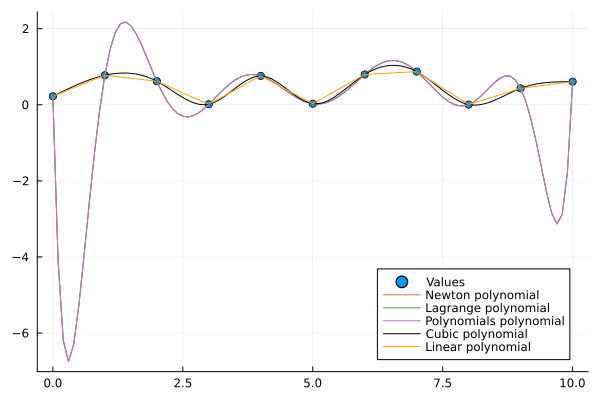

In [101]:
cub = CubicSplineInterpolation(x,y)
Cubic_pol = [cub[d] for d in dist]
lin = LinearInterpolation(x,y)
Linear_pol = [lin[d] for d in dist]
plot!(dist,Cubic_pol, label="Cubic polynomial", color = :black)
plot!(dist,Linear_pol, label="Linear polynomial", color = :orange)